(25, 4)
(10000,)
0 episode score is -160.00


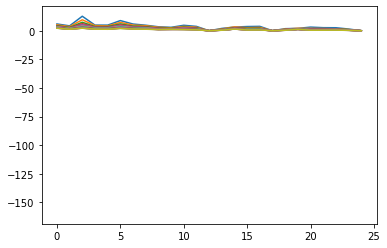

In [16]:
import gym
import pylab
import numpy as np
from gridworld import Gridworld
import matplotlib.pyplot as plt

from maxent import *

n_states = 25 
n_actions = 4
one_feature = 20 # number of state per one feature
q_table = np.zeros((n_states, n_actions)) # (400, 3)
print(q_table.shape)
feature_matrix = np.eye((n_states)) # (400, 400)

gamma = 1
q_learning_rate = 0.03
theta_learning_rate = 0.005

np.random.seed(1)

def idx_demo(env, one_feature):
    # env_low = env.observation_space.low     
    # env_high = env.observation_space.high   
    # env_distance = (env_high - env_low) / one_feature  

    raw_demo = np.load(file="expert_demo/expert_demo.npy", allow_pickle = True)
    print(raw_demo.shape)
    # demonstrations = np.zeros((len(raw_demo), len(raw_demo[0]), 3))

    # for x in range(len(raw_demo)):
    #     for y in range(len(raw_demo[0])):
    #         position_idx = int((raw_demo[x][y][0] - env_low[0]) / env_distance[0])
    #         velocity_idx = int((raw_demo[x][y][1] - env_low[1]) / env_distance[1])
    #         state_idx = position_idx + velocity_idx * one_feature

    #         demonstrations[x][y][0] = state_idx
    #         demonstrations[x][y][1] = raw_demo[x][y][2] 
            
    return raw_demo

def idx_state(env, state):
    # env_low = env.observation_space.low
    # env_high = env.observation_space.high 
    # env_distance = (env_high - env_low) / one_feature 
    # position_idx = int((state[0] - env_low[0]) / env_distance[0])
    # velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    # state_idx = position_idx + velocity_idx * one_feature
    return state

def update_q_table(state, action, reward, next_state):
    q_1 = q_table[state][1]
    q_2 = reward + gamma * max(q_table[next_state])
    q_table[state][action] += q_learning_rate * (q_2 - q_1)

env = Gridworld()

# env = gym.make('MountainCar-v0')
demonstrations = idx_demo(env, one_feature)

expert = expert_feature_expectations(feature_matrix, demonstrations)
# plt.plot(expert)
learner_feature_expectations = np.zeros(n_states)

theta = -(np.random.uniform(size=(n_states,)))

episodes, scores = [], []

for episode in range(1000):
    env.reset()
    state = 0
    score = 0


    if (episode != 0 and episode == 50) or (episode > 50 and episode % 50 == 0):
        learner = learner_feature_expectations / episode
        plt.plot(learner)
        maxent_irl(expert, learner, theta, theta_learning_rate)

    while True:
        state_idx = idx_state(env, state)
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)

        irl_reward = get_reward(feature_matrix, theta, n_states, state_idx)
        # print(irl_reward)
        next_state_idx = idx_state(env, next_state)
        update_q_table(state_idx, action, irl_reward, next_state_idx)

        learner_feature_expectations += feature_matrix[int(state_idx)]

        score += reward
        state = next_state

        if done:
            scores.append(score)
            episodes.append(episode)
            break

    if episode % 1000 == 0:
        score_avg = np.mean(scores)
        print('{} episode score is {:.2f}'.format(episode, score_avg))
        pylab.plot(episodes, scores, 'b')
        pylab.savefig("./learning_curves/maxent_30000.png")
        np.save("./results/maxent_q_table", arr=q_table)

In [12]:
np.argmax(q_table, axis=1)

array([3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 0, 0, 3, 1, 0, 0, 0, 3, 1, 0, 1,
       3, 3, 0])

In [13]:
human_policy = [3,3,3,3,1,\
                0,3,3,3,1,\
                0,1,3,3,1,\
                0,2,0,3,1,\
                0,2,3,3,0]

sum(1 for i in range(25) if np.argmax(q_table, axis=1)[i]==human_policy[i])

18

10

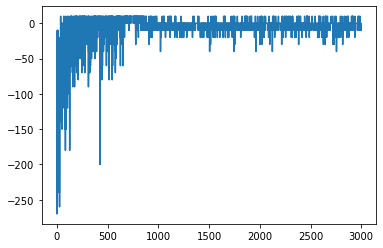

In [10]:
plt.plot(scores)
max(scores)